In [20]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import np_utils

In [21]:
def vlb_binomial(x, x_decoded_mean, t_mean, t_log_var):
    """Returns the value of Variational Lower Bound
    
    The inputs are tf.Tensor
        x: (batch_size x number_of_pixels) matrix with one image per row with zeros and ones
        x_decoded_mean: (batch_size x number_of_pixels) mean of the distribution p(x | t), real numbers from 0 to 1
        t_mean: (batch_size x latent_dim) mean vector of the (normal) distribution q(t | x)
        t_log_var: (batch_size x latent_dim) logarithm of the variance vector of the (normal) distribution q(t | x)
    
    Returns:
        A tf.Tensor with one element (averaged across the batch), VLB
    """
    ### YOUR CODE HERE
    kl = tf.reduce_sum((tf.exp(t_log_var) + t_mean**2 - t_log_var - 1)/2.0, 1)
    reconstruction_loss = -tf.reduce_sum(x*tf.log(x_decoded_mean+1e-8)+(1-x)*tf.log(1-x_decoded_mean+1e-8), 1)
    kl = tf.reduce_mean(kl)
    reconstruction_loss = tf.reduce_mean(reconstruction_loss)
    return reconstruction_loss+kl

In [22]:
# Start tf session so we can run code.
sess = tf.InteractiveSession()
# Connect keras to the created session.
K.set_session(sess)

/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [23]:
batch_size = 100
original_dim = 784 # Number of pixels in MNIST images.
latent_dim = 16 # d, dimensionality of the latent code t.
intermediate_dim = 512 # Size of the hidden layer.
epochs = 20

x = Input(batch_shape=(None, original_dim))
def create_encoder(input_dim):
    # Encoder network.
    # We instantiate these layers separately so as to reuse them later
    encoder = Sequential(name='encoder')
    encoder.add(InputLayer([input_dim]))
    encoder.add(Dense(intermediate_dim, activation='relu'))
    encoder.add(Dense(intermediate_dim//2, activation='relu'))
    encoder.add(Dense(2 * latent_dim))
    return encoder
encoder = create_encoder(original_dim)

get_t_mean = Lambda(lambda h: h[:, :latent_dim])
get_t_log_var = Lambda(lambda h: h[:, latent_dim:])
h = encoder(x)
t_mean = get_t_mean(h)
t_log_var = get_t_log_var(h)

# Sampling from the distribution 
#     q(t | x) = N(t_mean, exp(t_log_var))
# with reparametrization trick.
def sampling(args):
    """Returns sample from a distribution N(args[0], diag(args[1]))
    
    The sample should be computed with reparametrization trick.
    
    The inputs are tf.Tensor
        args[0]: (batch_size x latent_dim) mean of the desired distribution
        args[1]: (batch_size x latent_dim) logarithm of the variance vector of the desired distribution
    
    Returns:
        A tf.Tensor of size (batch_size x latent_dim), the samples.
    """
    t_mean, t_log_var = args
    # YOUR CODE HERE
    return t_mean + tf.exp(0.5*t_log_var) * tf.random_normal(tf.shape(t_mean), 0, 1, dtype=tf.float32)

t = Lambda(sampling)([t_mean, t_log_var])

def create_decoder(input_dim):
    # Decoder network
    # We instantiate these layers separately so as to reuse them later
    decoder = Sequential(name='decoder')
    decoder.add(InputLayer([input_dim]))
    decoder.add(Dense(intermediate_dim//2, activation='relu'))
    decoder.add(Dense(intermediate_dim, activation='relu'))
    decoder.add(Dense(original_dim, activation='sigmoid'))
    return decoder
decoder = create_decoder(latent_dim)
x_decoded_mean = decoder(t)

In [24]:
loss = vlb_binomial(x, x_decoded_mean, t_mean, t_log_var)
vae = Model(x, x_decoded_mean)
# Keras will provide input (x) and output (x_decoded_mean) to the function that
# should construct loss, but since our function also depends on other
# things (e.g. t_means), it is easier to build the loss in advance and pass
# a function that always returns it.
vae.compile(optimizer=keras.optimizers.RMSprop(lr=0.001), loss=lambda x, y: loss)

In [25]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# One hot encoding.
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [26]:
hist = vae.fit(x=x_train, y=x_train,
               shuffle=True,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(x_test, x_test),
               verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
 - 16s - loss: 156.5752 - val_loss: 131.1152
Epoch 2/20
 - 16s - loss: 123.9501 - val_loss: 116.6150
Epoch 3/20
 - 18s - loss: 115.9018 - val_loss: 112.3951
Epoch 4/20
 - 17s - loss: 112.1935 - val_loss: 109.8479
Epoch 5/20
 - 17s - loss: 109.8614 - val_loss: 107.9521
Epoch 6/20
 - 16s - loss: 108.2869 - val_loss: 108.0157
Epoch 7/20
 - 15s - loss: 107.1480 - val_loss: 107.1204
Epoch 8/20
 - 15s - loss: 106.1998 - val_loss: 106.3541
Epoch 9/20
 - 16s - loss: 105.5105 - val_loss: 105.4304
Epoch 10/20
 - 17s - loss: 104.8969 - val_loss: 104.6601
Epoch 11/20
 - 15s - loss: 104.4161 - val_loss: 104.1094
Epoch 12/20
 - 15s - loss: 103.9960 - val_loss: 103.7703
Epoch 13/20
 - 16s - loss: 103.5832 - val_loss: 103.6059
Epoch 14/20
 - 17s - loss: 103.3161 - val_loss: 104.0599
Epoch 15/20
 - 17s - loss: 103.0156 - val_loss: 103.3160
Epoch 16/20
 - 17s - loss: 102.7759 - val_loss: 102.6626
Epoch 17/20
 - 17s - loss: 102.5548 - val_loss:

In [27]:
#Hallucinate new data

In [28]:
x_train.shape

(60000, 784)

In [29]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_20 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_21 (Dense)             (None, 32)                8224      
Total params: 541,472
Trainable params: 541,472
Non-trainable params: 0
_________________________________________________________________


In [30]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 256)               4352      
_________________________________________________________________
dense_23 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_24 (Dense)             (None, 784)               402192    
Total params: 538,128
Trainable params: 538,128
Non-trainable params: 0
_________________________________________________________________


In [31]:
# One-hot labels placeholder.
x = Input(batch_shape=(None, original_dim))
label = Input(batch_shape=(None, 10))
encoder = create_encoder(original_dim+10)

get_cond_t_mean = Lambda(lambda h: h[:, :latent_dim])
get_cond_t_log_var = Lambda(lambda h: h[:, latent_dim:])
h = encoder(concatenate([x, label]))

# YOUR CODE HERE.
cond_t_mean =  get_cond_t_mean(h)# Mean of the latent code (without label) for cvae model.
cond_t_log_var = get_cond_t_log_var(h)# Logarithm of the variance of the latent code (without label) for cvae model.
t = Lambda(sampling)([cond_t_mean, cond_t_log_var])
decoder = create_decoder(latent_dim+10)
cond_x_decoded_mean = decoder(concatenate([t, label])) # Final output of the cvae model.

In [32]:
conditional_loss = vlb_binomial(x, cond_x_decoded_mean, cond_t_mean, cond_t_log_var)
cvae = Model([x, label], cond_x_decoded_mean)
cvae.compile(optimizer=keras.optimizers.RMSprop(lr=0.001), loss=lambda x, y: conditional_loss)

In [33]:
hist = cvae.fit(x=[x_train, y_train],
                y=x_train,
                shuffle=True,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=([x_test, y_test], x_test),
                verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
 - 16s - loss: 151.6865 - val_loss: 126.5782
Epoch 2/20
 - 16s - loss: 120.9626 - val_loss: 115.0794
Epoch 3/20
 - 16s - loss: 113.1904 - val_loss: 109.3360
Epoch 4/20
 - 16s - loss: 109.3663 - val_loss: 107.8111
Epoch 5/20
 - 16s - loss: 106.9284 - val_loss: 104.8728
Epoch 6/20
 - 15s - loss: 105.2200 - val_loss: 103.8853
Epoch 7/20
 - 16s - loss: 103.8586 - val_loss: 103.1389
Epoch 8/20
 - 17s - loss: 102.8058 - val_loss: 103.4636
Epoch 9/20
 - 16s - loss: 101.9787 - val_loss: 101.5260
Epoch 10/20
 - 17s - loss: 101.2864 - val_loss: 101.1045
Epoch 11/20
 - 15s - loss: 100.6589 - val_loss: 100.8514
Epoch 12/20
 - 15s - loss: 100.1878 - val_loss: 100.3307
Epoch 13/20
 - 16s - loss: 99.7230 - val_loss: 100.3944
Epoch 14/20
 - 15s - loss: 99.3189 - val_loss: 99.9641
Epoch 15/20
 - 17s - loss: 98.9344 - val_loss: 99.4282
Epoch 16/20
 - 16s - loss: 98.6509 - val_loss: 99.0623
Epoch 17/20
 - 16s - loss: 98.3371 - val_loss: 99.3774

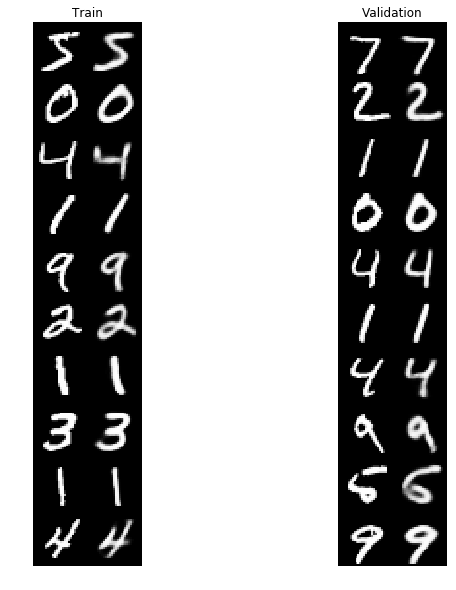

In [34]:
fig = plt.figure(figsize=(10, 10))
for fid_idx, (x_data, y_data, title) in enumerate(
            zip([x_train, x_test], [y_train, y_test], ['Train', 'Validation'])):
    n = 10  # figure with 10 x 2 digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * 2))
    decoded = sess.run(cond_x_decoded_mean,
                       feed_dict={x: x_data[:batch_size, :],
                                  label: y_data[:batch_size, :]})
    for i in range(10):
        figure[i * digit_size: (i + 1) * digit_size,
               :digit_size] = x_data[i, :].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    ax = fig.add_subplot(1, 2, fid_idx + 1)
    ax.imshow(figure, cmap='Greys_r')
    ax.set_title(title)
    ax.axis('off')
plt.show()


In [35]:
# Prepare one hot labels of form
#   0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 ...
# to sample five zeros, five ones, etc
curr_labels = np.eye(10)
curr_labels = np.repeat(curr_labels, 5, axis=0)  # Its shape is 50 x 10.
# YOUR CODE HERE.
sample_t_from_x = sess.run(t, feed_dict={x: x_data[:, :], label: y_data[:, :]})
t_means = sample_t_from_x.mean(axis=0)
t_std = sample_t_from_x.std(axis=0)
sample_t = np.random.normal(t_means, t_std, (50, latent_dim))
# ...
# cond_sampled_im_mean is a tf.Tensor of size 50 x 784 with 5 random zeros,
# then 5 random ones, etc sampled from the cvae model.
cond_sampled_im_mean = sess.run(cond_x_decoded_mean, feed_dict={t: sample_t, label:curr_labels})

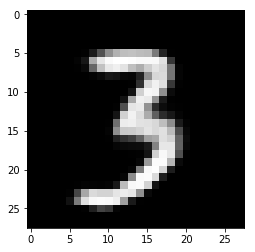

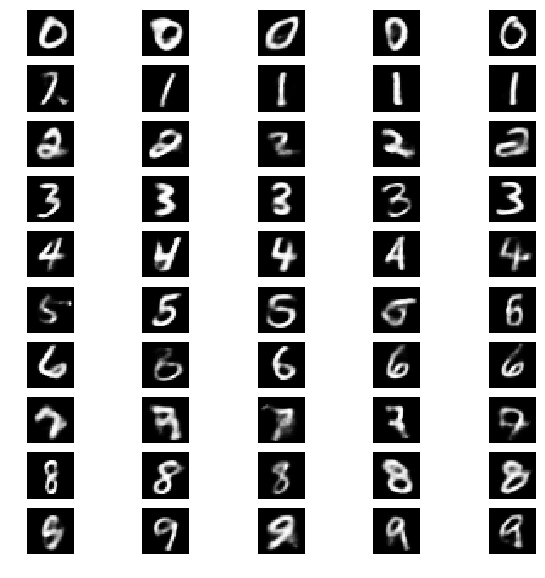

In [41]:
#Show individual samples
cond_sampled_im_mean_np = cond_sampled_im_mean
plt.imshow(cond_sampled_im_mean_np[15,:].reshape(28, 28), cmap='gray')
plt.show()

# Show the sampled images.
plt.figure(figsize=(10, 10))
global_idx = 0
for digit in range(10):
    for _ in range(5):
        ax = plt.subplot(10, 5, global_idx + 1)
        plt.imshow(cond_sampled_im_mean_np[global_idx, :].reshape(28, 28), cmap='gray')
        ax.axis('off')
        global_idx += 1
plt.show()